## Dollar Street dataset
#### Imports

In [1]:
import ast
import os
from PIL import Image
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

# from datasets.dollarstreet import get_dollarstreet

#### Load CSV
Data downloaded from Kaggle: 
```
kaggle datasets download -d mlcommons/the-dollar-street-dataset -p /mfsnic/u/apouget/data/dollarstreet/
unzip /mfsnic/u/apouget/data/dollarstreet/the-dollar-street-dataset.zip -d /mfsnic/u/apouget/data/dollarstreet
```

In [2]:
dataset_path = '/mfsnic/u/apouget/data/dollarstreet/dataset_dollarstreet/'
train_path = os.path.join(dataset_path, 'images_v2_imagenet_train.csv')
test_path = os.path.join(dataset_path, 'images_v2_imagenet_test.csv')

data_train_csv = pd.read_csv(train_path)
data_test_csv = pd.read_csv(test_path)
# display(data_train_csv.head())

#### Create torch dataset

In [3]:
class DollarStreetDataset(Dataset):
    def __init__(self, csv_file, root_dir, pre_filter=None, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        if pre_filter:
            self.data = self.data[self.data.apply(pre_filter, axis=1)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 5]) # 5 is the column imageRelPath
        image = Image.open(img_name).convert("RGB")
        label = ast.literal_eval(self.data.iloc[idx, 10])[0] # 10 is the column imagenet_sysnet_id, taking the first label

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
transform = transforms.Compose([
    transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.4333, 0.3959, 0.3595], [0.2046, 0.2008, 0.2011])
])

data_train = DollarStreetDataset(csv_file=train_path, root_dir=dataset_path, transform=transform)
dataloader_train = DataLoader(data_train, batch_size=64, shuffle=False, num_workers=4)
data_test = DollarStreetDataset(csv_file=test_path, root_dir=dataset_path, transform=transform)
dataloader_test = DataLoader(data_test, batch_size=64, shuffle=False, num_workers=4)

#### Check model accuracy

In [9]:
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_accuracy_and_confidence(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    confidence_scores = []
    correctness = np.array([])
    
    with torch.no_grad():  # No need to calculate gradients for evaluation
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Get the predicted class by taking the argmax of the output tensor
            _, predicted = torch.max(outputs.data, 1)
            softmax_scores = F.softmax(outputs, dim=1)
            max_confidences, _ = torch.max(softmax_scores, dim=1)
            confidence_scores.extend(max_confidences.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            correctness = np.append(correctness, (predicted == labels).cpu().numpy())
    
    accuracy = correct / total * 100
    return accuracy, confidence_scores, np.array(correctness, dtype=bool)

# print(get_accuracy_and_confidence(model, dataloader_test, device)[0]) # 23.81615598885794

#### Check model accuracy and prediction confidence per region

In [17]:
REGIONS = data_test_csv['region.id'].unique()
confidences = {}
correctness = {}

for region in REGIONS:
    data_test_filtered = DollarStreetDataset(csv_file=test_path, root_dir=dataset_path, pre_filter=lambda x: x['region.id'] == region, transform=transform)
    dataloader_test_filtered = DataLoader(data_test_filtered, batch_size=64, shuffle=False, num_workers=4)
    acc, conf, corr = get_accuracy_and_confidence(model, dataloader_test_filtered, device)
    confidences[region] = conf
    correctness[region] = corr
    print(f'Region {region}: {acc}')
# Region as: 22.25117248566962
# Region am: 28.971962616822427
# Region af: 15.11216056670602
# Region eu: 32.50728862973761

Region as: 22.25117248566962
Region am: 28.971962616822427
Region af: 15.11216056670602
Region eu: 32.50728862973761


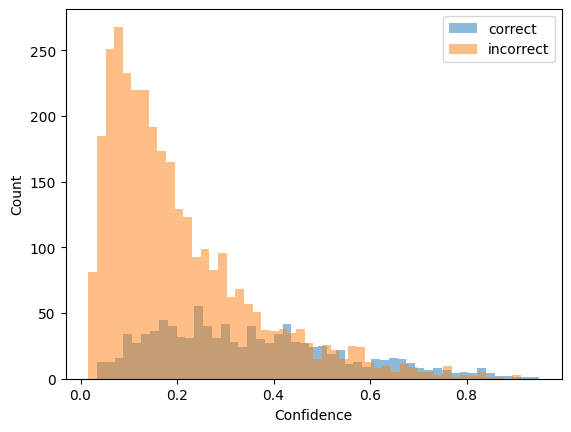

In [22]:
all_corr = np.concatenate(list(correctness.values()))
all_conf = np.concatenate(list(confidences.values()))

plt.hist(all_conf[all_corr], bins=50, alpha=0.5, label='correct')
plt.hist(all_conf[~all_corr], bins=50, alpha=0.5, label='incorrect')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.legend()
plt.show()

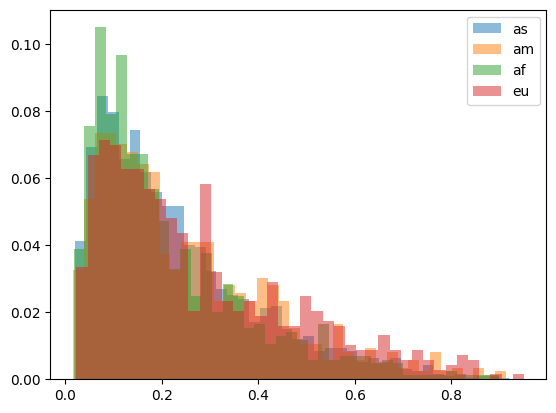

In [15]:
for key, value in confidences.items():
    plt.hist(value, bins=40, alpha=0.5, label=key, weights=np.ones_like(value)/len(value))
plt.legend(loc='upper right')
plt.show()

#### Implement decision boundary check from dataset inference (robustness)

In [6]:
def get_rand_steps(model, dataloader, device, max_steps, metric, pert=0.005):
    # loosely based on https://github.com/cleverhans-lab/dataset-inference/blob/main/src/attacks.py
    assert metric in ["l1", "l2", "linf"], f"Metric {metric} not supported, pick one of ['l1', 'l2', 'linf']"

    model.eval()
    max_mag_per_image = np.array([])
    corr_pred = np.array([])

    # Define noise
    l1_noise = lambda X: torch.from_numpy(np.random.laplace(loc=0.0, scale=2*pert, size=X.shape)).float().to(device) 
    l2_noise = lambda X: torch.normal(0, pert, size=X.shape).to(device)
    linf_noise = lambda X: torch.empty_like(X).uniform_(-pert, pert).to(device)
    noise = {"l1": l1_noise, "l2": l2_noise, "linf": linf_noise}
    
    with torch.no_grad():  # No need to calculate gradients for evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            labels_pred = torch.argmax(model(images), dim=1)
            corr_pred = np.append(corr_pred, (labels_pred == labels).cpu().numpy())

            max_step = torch.ones(images.size(0)).to(device)
            remaining = torch.ones(images.size(0)).to(device).bool()
            delta = noise[metric](images)
            
            for i in range(1, max_steps):
                preds = model(images+i*delta)
                remaining = remaining & (torch.max(preds.data, 1)[1] == labels_pred)
                max_step[remaining] = i*torch.ones_like(max_step[remaining])
                if remaining.sum() == 0:
                    break
            max_mag_per_image = np.append(max_mag_per_image, max_step.cpu().numpy())

    return max_mag_per_image, corr_pred

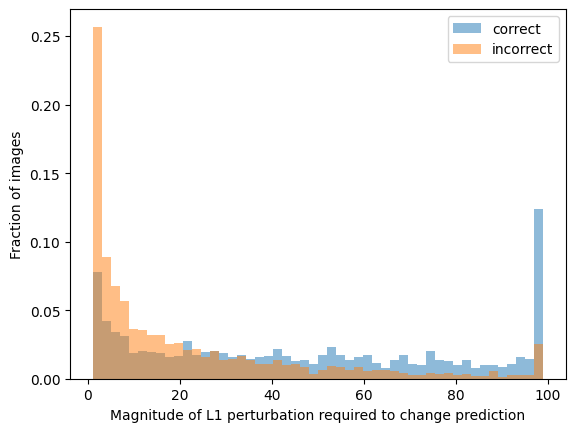

In [8]:
delta, corr_pred = get_rand_steps(model, dataloader_test, device, 100, "l1")
is_corr = np.array(corr_pred, dtype=bool)
plt.hist(delta[is_corr], bins=50, alpha=0.5, label='correct', weights=np.ones_like(delta[is_corr])/len(delta[is_corr]))
plt.hist(delta[~is_corr], bins=50, alpha=0.5, label='incorrect', weights=np.ones_like(delta[~is_corr])/len(delta[~is_corr]))
plt.xlabel('Magnitude of L1 perturbation required to change prediction')
plt.ylabel('Fraction of images')
plt.legend(loc='upper right')
plt.show()

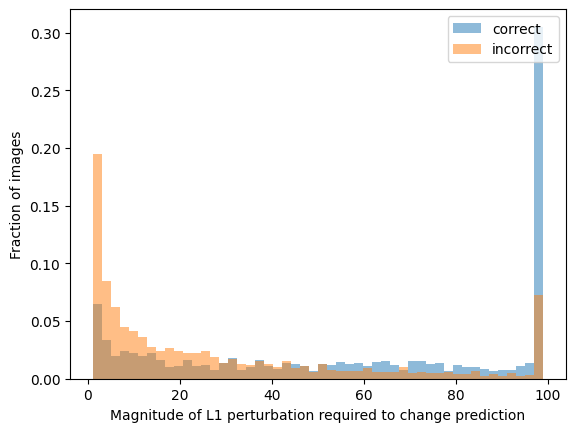

In [12]:
delta, corr_pred = get_rand_steps(model, dataloader_test, device, 100, "l2", pert=0.01)
is_corr = np.array(corr_pred, dtype=bool)
plt.hist(delta[is_corr], bins=50, alpha=0.5, label='correct', weights=np.ones_like(delta[is_corr])/len(delta[is_corr]))
plt.hist(delta[~is_corr], bins=50, alpha=0.5, label='incorrect', weights=np.ones_like(delta[~is_corr])/len(delta[~is_corr]))
plt.xlabel('Magnitude of L1 perturbation required to change prediction')
plt.ylabel('Fraction of images')
plt.legend(loc='upper right')
plt.show()

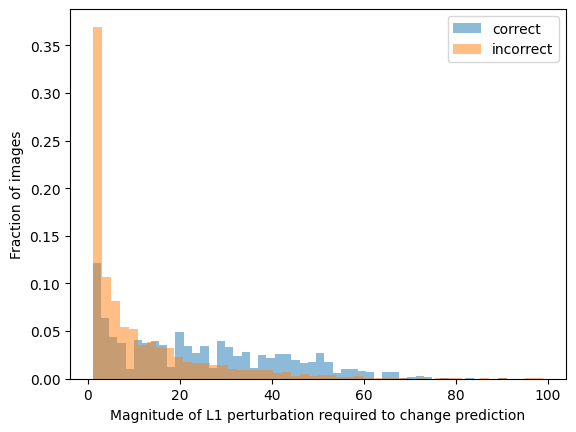

In [16]:
delta, corr_pred = get_rand_steps(model, dataloader_test, device, 100, "linf", pert=0.05)
is_corr = np.array(corr_pred, dtype=bool)
plt.hist(delta[is_corr], bins=50, alpha=0.5, label='correct', weights=np.ones_like(delta[is_corr])/len(delta[is_corr]))
plt.hist(delta[~is_corr], bins=50, alpha=0.5, label='incorrect', weights=np.ones_like(delta[~is_corr])/len(delta[~is_corr]))
plt.xlabel('Magnitude of L1 perturbation required to change prediction')
plt.ylabel('Fraction of images')
plt.legend(loc='upper right')
plt.show()